# Compare GCV OCR Results

Compare results from 2019 run with results from different combinations of language hints today.

GCV Documentation for:
* [client libraries](https://cloud.google.com/vision/docs/quickstart-client-libraries#client-libraries-install-python)
* [OCR](https://cloud.google.com/vision/docs/ocr)

TODO: take a look at whether any of these could be helpful:

https://cloud.google.com/vision/docs/reference/rpc/google.cloud.vision.v1#google.cloud.vision.v1.TextDetectionParams
https://cloud.google.com/vision/docs/reference/rpc/google.cloud.vision.v1#google.cloud.vision.v1.ImageContext

In [1]:
%load_ext sql

In [2]:
import hashlib
import io
import json
import os
import re
import subprocess
import sys
import warnings
from itertools import zip_longest
from pathlib import Path, PurePath
from pprint import pprint

import numpy as np
import pandas as pd
import seaborn as sns

# from wand.image import Image
from IPython.display import Image
from nltk.metrics import edit_distance

sns.set_style("dark")

In [3]:
import Levenshtein
import Levenshtein_search
import polyleven

## Load OCR 2019 Results

In [4]:
%sql postgresql:///pfocr20200224

In [5]:
%%sql ocr_2019 << SELECT pmcid, figure_number, result->'textAnnotations'->0->'locale' AS locale, result->'textAnnotations'->0->'description' AS text
FROM ocr_processors__figures
INNER JOIN ocr_processors ON ocr_processors__figures.ocr_processor_id = ocr_processors.id
INNER JOIN figures ON ocr_processors__figures.figure_id=figures.id
INNER JOIN papers ON figures.paper_id = papers.id;

 * postgresql:///pfocr20200224
114176 rows affected.
Returning data to local variable ocr_2019


In [6]:
ocr_2019_df = ocr_2019.DataFrame()

## Load Sample (2021) OCR Results

In [7]:
figures_dir_path = Path("../data/images/sample_20210506")

figure_paths = list()
for ext in ("*.jpg", "*.jpeg", "*.png"):
    for f in figures_dir_path.rglob(ext):
        figure_paths.append(f)

results = dict()

# "el" is modern Greek
# "grc" is ancient greek
# "got" is Gothic, which maps to "Latin script model".
# .     I think that means it just tries to recognize Latin script characters.
# "fy" is western Frisian, mapping to generic Latin script model
language_hints_args = [
    # I am calling the following "unspecified":
    [],
    #
    ["en"],
    #
    # ==============================================
    # the following lines produce identical results:
    ["el"],
    ["en", "el"],
    ["en", "grc"],
    # --------------------------
    #
    # ==============================================
    # the following lines produce identical results:
    ["got"],
    # ["got", "Grek"],
    # --------------------------
    #
    ["fy"],
    #
    # ==============================================
    # the following lines produce identical results:
    ["grc"],
    ["got", "grc"],
    ["got", "el"],
    ["got", "el", "grc"],
    # ["el", "grc"],
    # --------------------------
    #
    ["en", "got", "grc"],
    ["en", "got", "el"],
]


image_sample_rows = list()

for figure_path in figure_paths:
    figure_path_key = str(figure_path)
    # figure_path_key = figure_path.name
    results[figure_path_key] = dict()

    figure_number = figure_path.stem

    for language_hints in language_hints_args:
        readable_language_hints = language_hints.copy()
        if len(readable_language_hints) == 0:
            readable_language_hints.append("unspecified")

        # Specifying utf8 and 'ensure_ascii=False' ensures the output file uses
        # Greek characters, not escape encoding like "\u..."
        with figure_path.with_name(
            "_".join([figure_path.stem] + readable_language_hints)
        ).with_suffix(".json").open(encoding="utf8") as f:
            text_annotations = json.load(f)
            results[figure_path_key][
                tuple(readable_language_hints)
            ] = text_annotations

        image_sample_rows.append(
            {
                "figure_number": figure_number,
                "year_run": 2021,
                "language_hints": readable_language_hints,
                "text": text_annotations[0]["description"],
                "locale": text_annotations[0]["locale"],
            }
        )
sample_ocr_2021_df = pd.DataFrame(image_sample_rows)

## Merge OCR Results

This is all just looking at the sample set of images.

In 2019, we probably didn't specify a language hint. For 2021, I tried multiple different language hints.

In [8]:
figure_numbers = set()
for figure_path in figure_paths:
    figure_numbers.add(figure_path.stem)

sample_ocr_2019_df = ocr_2019_df[
    ocr_2019_df["figure_number"].isin(figure_numbers)
].copy(deep=True)
sample_ocr_2019_df["year_run"] = 2019
# TODO: the following is messy. I just want a column where every value is ["unspecified"]
sample_ocr_2019_df["language_hints"] = sample_ocr_2019_df["year_run"].apply(
    lambda x: ["unspecified"]
)
ocr_df = pd.concat([sample_ocr_2021_df, sample_ocr_2019_df], ignore_index=True)

ocr_df["ocr_spec"] = (
    ocr_df["year_run"].apply(lambda year_run: str(year_run))
    + " "
    + ocr_df["language_hints"].str.join("+")
)

ocr_df["figure_path"] = ocr_df["figure_number"].apply(
    lambda x: figures_dir_path.joinpath(f"{x}.jpg")
)

ocr_df.sort_values(["ocr_spec", "figure_number"], inplace=True)
ocr_df.reset_index(inplace=True, drop=True)
ocr_df

,figure_number,year_run,language_hints,text,locale,pmcid,ocr_spec,figure_path
0,12859_2015_841_Fig6_HTML,2019,[unspecified],FAMIBBA\nRR13\nRPSA\nPPRCB\nPSB7\nEIF3F\nPSAS ...,en,PMC4697333,2019 unspecified,../data/images/sample_20210506/12859_2015_841_...
1,2042-4280-2-1-2,2019,[unspecified],Latent infection\nTRAIL\nType I FNs\nFas\nEBV\...,en,PMC3063194,2019 unspecified,../data/images/sample_20210506/2042-4280-2-1-2...
2,JCI37934.f2,2019,[unspecified],Plasmin\nPro-HGF\nSERPINE1\nuPA\nPlasminogen\n...,en,PMC2662567,2019 unspecified,../data/images/sample_20210506/JCI37934.f2.jpg
3,JLR4991981f8,2019,[unspecified],TGFB1\nTNFA\nInsulin\nInsulin signaling\nSmad ...,en,PMC2515524,2019 unspecified,../data/images/sample_20210506/JLR4991981f8.jpg
4,PROCATS62152f2,2019,[unspecified],Bronchioloalveolar\nCarcinoma\nNormal\nMicroin...,en,PMC2674225,2019 unspecified,../data/images/sample_20210506/PROCATS62152f2.jpg
...,...,...,...,...,...,...,...,...
190,nihms16392f3,2021,[unspecified],Insulin Receptor Signaling\nLigand\nWortmannin...,en,NaN,2021 unspecified,../data/images/sample_20210506/nihms16392f3.jpg
191,nihms219131f1,2021,[unspecified],"Upstream Regulators\nMsx2, Bapx1,\nDIx5, Hoxa1...",en,NaN,2021 unspecified,../data/images/sample_20210506/nihms219131f1.jpg
192,nihms312528f9,2021,[unspecified],HIV viral\nHIV infection\nT- Cell Activation\n...,en,NaN,2021 unspecified,../data/images/sample_20210506/nihms312528f9.jpg
193,nihms98138f3,2021,[unspecified],Plasmin\nincreased\nSignaling\nmolecules\nacti...,en,NaN,2021 unspecified,../data/images/sample_20210506/nihms98138f3.jpg


## Compare 2019 and 2021
Including all the different language hints we tried for 2021

### Compare Levenshtein Distances

<AxesSubplot:>

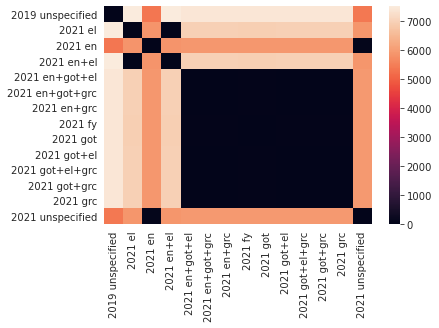

In [9]:
text_by_ocr_spec = dict()

for ocr_spec, df in ocr_df.groupby(by=["ocr_spec"], dropna=False):
    text_by_ocr_spec[ocr_spec] = "".join(list(df["text"]))

data = dict()
my_index = list()
my_items = text_by_ocr_spec.items()
for ocr_spec, text in my_items:
    my_index.append(ocr_spec)
    subdata = list()
    data[ocr_spec] = subdata
    for ocr_spec2, text2 in my_items:
        dist = Levenshtein.distance(text, text2)
        subdata.append(dist)

my_df = pd.DataFrame(data, index=my_index)
sns.heatmap(my_df)

Let's zoom in on the big cluster.

<AxesSubplot:>

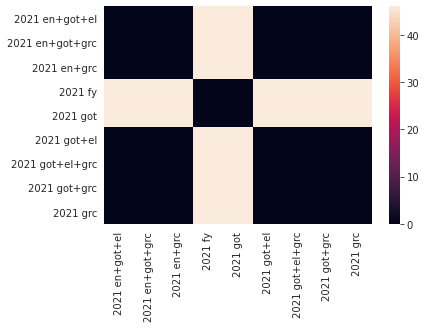

In [10]:
text_by_selected_ocr_spec = dict()

for ocr_spec, df in (
    ocr_df[
        ocr_df["ocr_spec"].isin(
            {
                "2021 en+got+el",
                "2021 en+got+grc",
                "2021 en+grc",
                "2021 fy",
                "2021 got",
                "2021 got+el",
                "2021 got+el+grc",
                "2021 got+grc",
                "2021 grc",
            }
        )
    ]
    .sort_values(["ocr_spec", "figure_number"])
    .groupby(by=["ocr_spec"], dropna=False)
):
    text_by_selected_ocr_spec[ocr_spec] = "".join(list(df["text"]))

levenshtein_selected_data = dict()
levenshtein_selected_index = list()

levenshtein_selected_items = text_by_selected_ocr_spec.items()

for ocr_spec, text in levenshtein_selected_items:
    levenshtein_selected_index.append(ocr_spec)
    subdata = list()
    levenshtein_selected_data[ocr_spec] = subdata
    for ocr_spec2, text2 in levenshtein_selected_items:
        dist = Levenshtein.distance(text, text2)
        subdata.append(dist)

levenshtein_selected_df = pd.DataFrame(
    levenshtein_selected_data, index=levenshtein_selected_index
)
sns.heatmap(levenshtein_selected_df)

### Compare Counts of Different Character by Script 

Group the OCR outputs by `ocr_spec` and concatenate across images. Then look at what types of characters are being detected -- Latin, Greek, Cyrillic, etc. -- and how the `ocr_spec` seems to be related.

In [11]:
concatenated_text_data = list()

# TODO: would be better to use something like df.group_by()
for ocr_spec, text in text_by_ocr_spec.items():
    concatenated_text_data.append(
        {"ocr_spec": ocr_spec, "concatenated_text": text}
    )

concatenated_text_df = pd.DataFrame(concatenated_text_data)
concatenated_text_df

,ocr_spec,concatenated_text
0,2019 unspecified,FAMIBBA\nRR13\nRPSA\nPPRCB\nPSB7\nEIF3F\nPSAS ...
1,2021 el,FAMBSA\nRPGI3\nRPD3A\nPSMA3\nPSMD 1\nCABD6\nRA...
2,2021 en,FAMBBA\nRRE13\nPPRCB\nRP3A\nPSB7\nEIF3F\nPSMB6...
3,2021 en+el,FAMBSA\nRPGI3\nRPD3A\nPSMA3\nPSMD 1\nCABD6\nRA...
4,2021 en+got+el,FAMBA\nRPL13\nPPP2CB\nRP23A\nPSMBT\nRELS FOL\n...
5,2021 en+got+grc,FAMBA\nRPL13\nPPP2CB\nRP23A\nPSMBT\nRELS FOL\n...
6,2021 en+grc,FAMBA\nRPL13\nPPP2CB\nRP23A\nPSMBT\nRELS FOL\n...
7,2021 fy,FAMBA\nRPL13\nPPP2CB\nRP23A\nPSMBT\nRELS FOL\n...
8,2021 got,FAMBA\nRPL13\nPPP2CB\nRP23A\nPSMBT\nRELS FOL\n...
9,2021 got+el,FAMBA\nRPL13\nPPP2CB\nRP23A\nPSMBT\nRELS FOL\n...


In [12]:
def get_match_count(pattern, text):
    match_count = 0
    for m in re.finditer(pattern, text):
        match_count += 1
    return match_count

In [13]:
selected_res_by_name = {
    "greek_upper": re.compile(r"[Α-Ω]"),
    "greek_lower": re.compile(r"[α-ω]"),
    # any letter that is not in the greek or latin scripts
    "other_script": re.compile(r"[^a-zA-Zα-ωΑ-Ω\W0-9]"),
    # any letter or underscore
    "letter": re.compile(r"\w"),
    # the characters in our lexicon (check this)
    "lexicon": re.compile(r"[\w\d\/\&\,\-\ ]"),
}

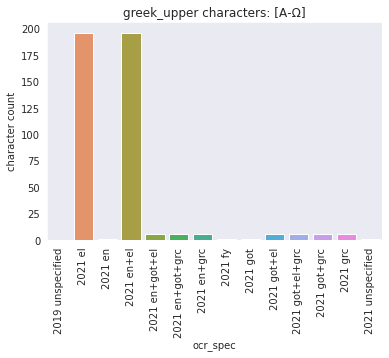

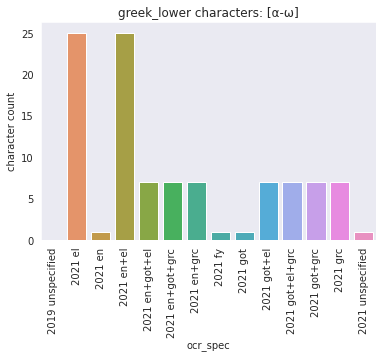

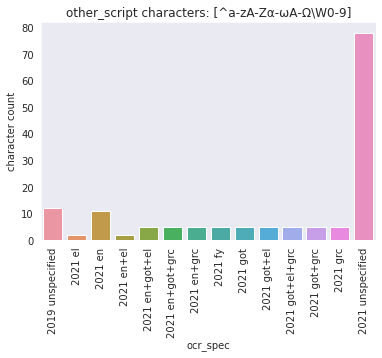

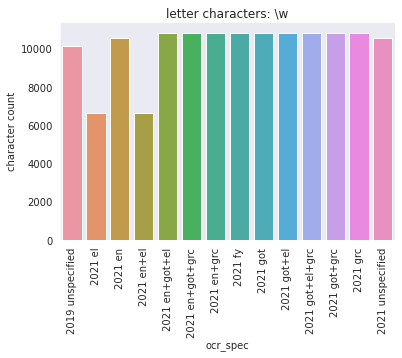

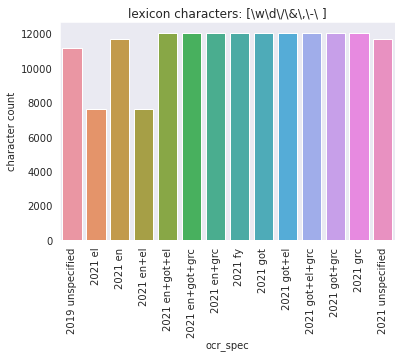

In [14]:
import matplotlib.pyplot as plt

for re_name, selected_re in selected_res_by_name.items():
    concatenated_text_df[re_name] = concatenated_text_df[
        "concatenated_text"
    ].apply(lambda t: get_match_count(selected_re, t))
    plt.figure()
    ax = sns.barplot(
        x="ocr_spec",
        y=re_name,
        data=concatenated_text_df,
    )
    ax.set(
        ylabel="character count",
        title=rf"{re_name} characters: {selected_re.pattern}",
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

## The Actual Images and OCR Text

`locale` is what GCV OCR thinks the language actually is.

================ ../data/images/sample_20210506/12859_2015_841_Fig6_HTML.jpg ================


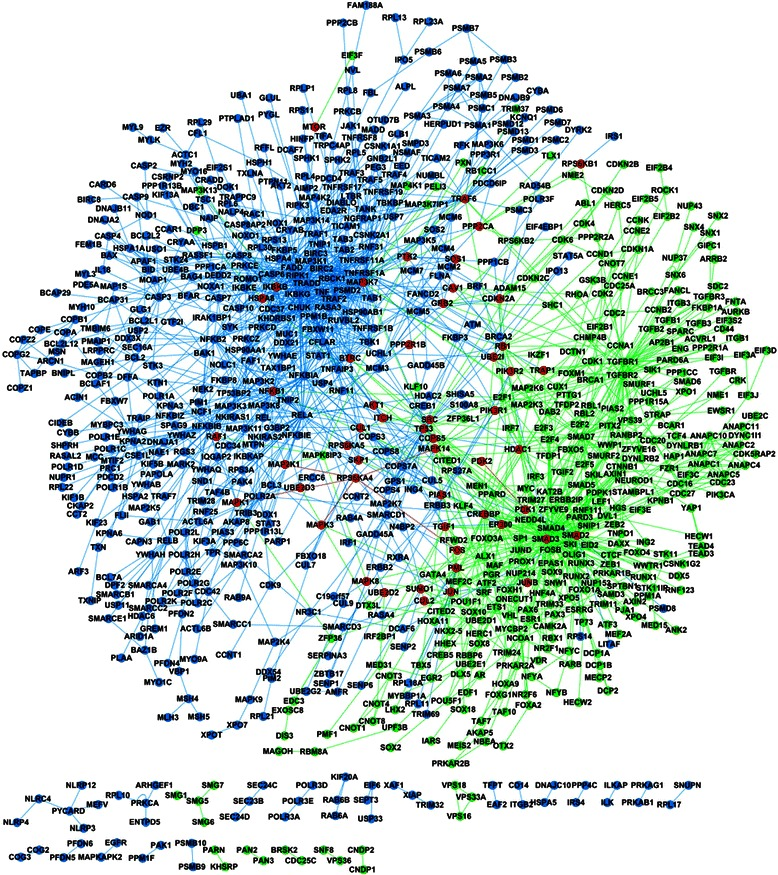


     ocr_spec locale
97    2021 fy     en
111  2021 got     en

'FAMBA\nRPL13\nPPP2CB\nRP23A\nPSMBT\nRELS FOL\nRPL PTPAD1\nJANIMADO\nREL DOI\nCSNIA1 SMPDS\nREX MAOOKS PSMO1 PSC2\nYOIF281\nMAPSK1001\nRIER\nNADPIRACI\nCRYABATIAN\nCOKE PPP2R2A\nSTOSA CONDI\n31 PPRCB\nMIT\nMOAPTBAA\nSNDCE\nBCKIMATIKE\nPSMD2\nCEKERE\nGSKOB CONE1\nCOC25A\nTGFORS FWTA\nFKBP1A AURKB\nTOFB2 SPARC\nTEK1 PPPOR18\nBCL2.12 PAPA DDEX\nLRPPRC SEGIGA\nMAGENS BCL2\nIK21 DOTN1\nEIF EAE1F30\nAGEN FIT\nKPNAS 1\nRBL2\nE2F4 SMADY\nEIFF\nPSMB6\nIROS\nPSGAS PSB3\nNVL\nPSMAS PSKAZ PSB2\nRPOP1\nALPL\nPSMAT\nUBA1 GCUL\nPS5DNOBS\nCYBA\nPSMA4 PSMCI TRIM37 PSMD6\nRP811\nPEOL\nPRKCB\nOTUD7B\nPSMAS\nKCNO1\nMYL9 EZR\nMTOR\nHERPUD1 PSMAPSN DIE\nPSDT\nCA1\nPSMD13\nMYLK\nDYRK2\nGOB1\nTNFRSF\nAQTC1\nNSWAF\nSP K1 SPEK2\nPSMD3\nGNB2L1\nPPPORT\nHSPH1\nTICAM2\nCASP2 MYH2\nTUX1\nPXN\nPEG3 LED\nRPSKB1 CDKN28 E1F2B4\nTXUNA\nCSRNP2\nRBCC\nTRAF4 NUMBL\nNMEZ\nCARD\nCRADO\nPPP130\nTRAFS\nPTEM\nAMP2\nMAPAKI PELIS\nPDGD6IP RAD346\nTNFRS19\nCDKN2D ROC

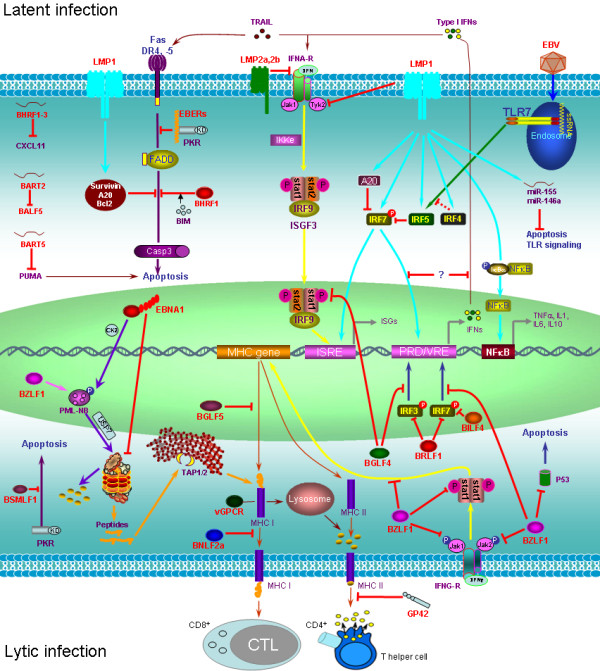


           ocr_spec locale
1  2019 unspecified     en

'Latent infection\nTRAIL\nType I FNs\nFas\nEBV\nDR4, 5\nLMP23,2b IFNA-R\nLMP1\nLMP1\nTLR7\nEBERS\n"T"\nBHRF1-3\nED\nEndoson\nIKKE\nPKR\nCXCL11\nFADD\nA20\nSurvivin\nA20\nBel2\nBART2\nmiR-155\nmiR-146a\nBHRF1\nIRF9\nBALFS\nIRF4\nIRF7\nIRF5\nBIM\nISGF3\nApoptosis\nTLR signaling\nBARTS\nCasp3\nNFRE\nApoptosis\nPUMA\nNFKB\nEBNA1\nTNFa, L1.\nL6, IL10\nIRF9\nISGS\nIFNS\nMHC gene\nISRE\nPROVRE\nNFKB\nBZLF1\nPM-NB\nIRFZ\nIRF3\nBGLF5\nBILF4\nApoptosis\nApoptosis\nBRLF1\nBGLF4\nTAP1.2\nP53\nLysosome\nBSMLF1\nVGPCR\nMHC I\nMHC I\nPeptides\nBZLFI\nBZLF1\nPKR\nBNLF2A\ntak1\n8888E\nMHC I\nMHC I\nFNG-R\nGP42\nCDS+\nCD4+\nCTL\nLytic infection\nThelper cell\nRNA\nstatt\nstat\nstat2 a\nstat\nstatt\nstaz\nUSP7\n'

             ocr_spec locale
28            2021 en     en
182  2021 unspecified     en

'Latent infection\nTRAIL\nType I IFNS\nFas\nEBV\nDRA. 5\nLMP1\nLMP23,2b IFNA-R\nLMP1\nTLR7\nEBERS\n"T"\nBHRF1-3\nED\nEndoson\nPKR\nCXCL11\nFADD\nA20\nS

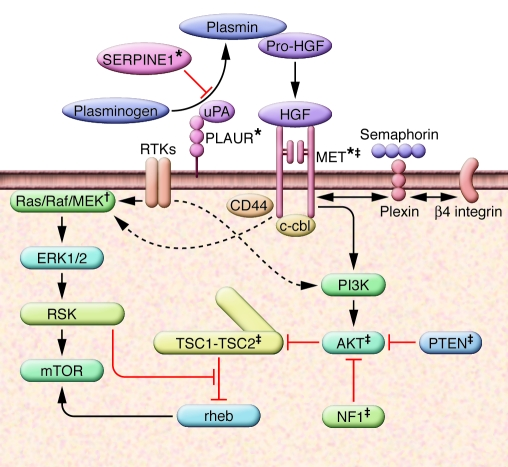


           ocr_spec locale
2  2019 unspecified     en

'Plasmin\nPro-HGF\nSERPINE1\nuPA\nPlasminogen\nHGF\nPLAUR*\nSemaphorin\nFUFMET** O0\nRTKS\nRas/Raf/MEKT\nCD44\nPlexin B4 integrin\nC-cbl\nERK1/2\nPI3K\nRSK\nTSC1-TSC2* E AKT*EPTEN\nMTOR\nrheb\nNF1*\n'

             ocr_spec locale
15            2021 el     en
29            2021 en     en
43         2021 en+el     en
57     2021 en+got+el     en
71    2021 en+got+grc     en
85        2021 en+grc     en
99            2021 fy     en
113          2021 got     en
127       2021 got+el     en
141   2021 got+el+grc     en
155      2021 got+grc     en
169          2021 grc     en
183  2021 unspecified     en

'Plasmin\nPro-HGF\nSERPINE1*\nPlasminogen\nUPA\nHGF\nPLAUR*\nSemaphorin\nFMET** Ow\nRTKS\nRas/Raf/MEK\nCD44\nC-cbl\nPlexin B4 integrin\nERK1/2\nPI3K\nRSK\nTSC1-TSC2AKT PTEN\nmTOR\nrheb\nNF1\n'


================ ../data/images/sample_20210506/JLR4991981f8.jpg ================


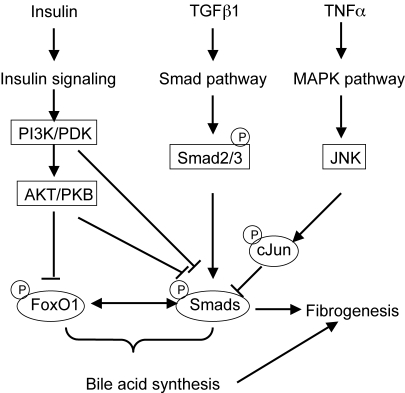


      ocr_spec locale
16     2021 el     en
44  2021 en+el     en

'Insulin\nTGF 1\nTNFα\nInsulin signaling\nSmad pathway MΑΡΚ pathway\nPI3K/PDK |\nSmad2/3\nJNK\nΑΚΤ/ΡΚΒ\nCJun)\nP.\nSmads\nFibrogenesis\nBile acid synthesis\n'

   ocr_spec locale
30  2021 en     en

'Insulin\nTGFB1\nTNFA\nInsulin signaling\nSmad pathway MAPK pathway\nPI3K/PDK\nP\nSmad2/3\nJNK\nAKT/PKB\ncJun\nP\nFox01\nSmads\nFibrogenesis\nBile acid synthesis\n'

             ocr_spec locale
184  2021 unspecified     en

'Insulin\nTGFB1\nTNFA\nInsulin signaling\nSmad pathway MAPK pathway\nPI3K/PDK\nP\nSmad2/3\nJNK\nАКТІРКВ\ncJun\nP\nFox01\nSmads\nFibrogenesis\nBile acid synthesis\n'

           ocr_spec locale
3  2019 unspecified     en

'TGFB1\nTNFA\nInsulin\nInsulin signaling\nSmad pathway\nMAPK pathway\nPI3K/PDK\nSmad2/3\nJNK\nAKT/PKB\ncJun\nFox01\nSmads\nFibrogenesis\nBile acid synthesis\n'

            ocr_spec locale
58    2021 en+got+el     en
72   2021 en+got+grc     en
86       2021 en+grc     en
100          2

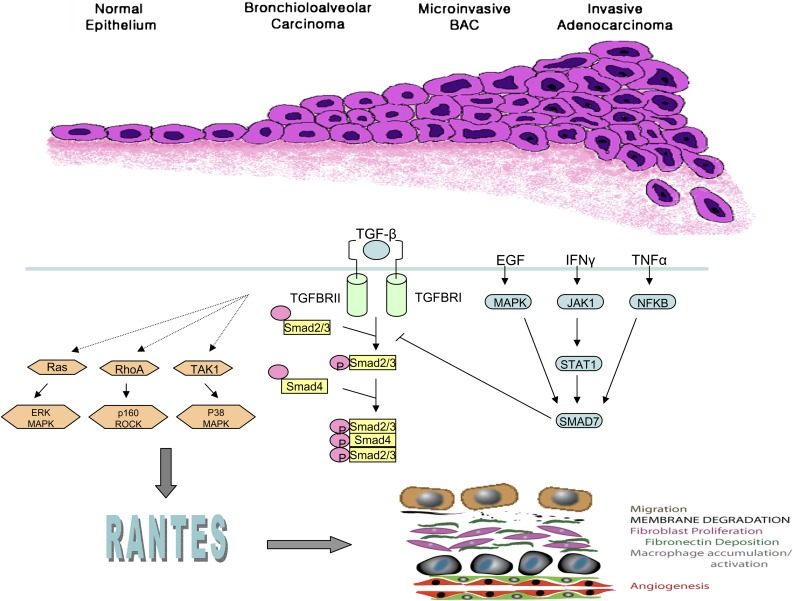


           ocr_spec locale
4  2019 unspecified     en

'Bronchioloalveolar\nCarcinoma\nNormal\nMicroinvasive\nBAC\nInvasive\nEpithelium\nAdenocarcinoma\nTGF-B\nEGF\nIFNY\nTNFA\nTGFBRI\nTGFBRII\nMAPK\nJAK1\nNFKB\nSmad2/3\nSmad2/3\n(STAT1\nRas\nRhoA\nTAK1\nSmad4\nERK\np160\nROCK\nP38\n(SMAD7\nMAPK\nMAPK\nSmad2/3\nSmad4\nSmad2/3\nMigration\nMEMBRANE DEGRADATION\nFibroblast Proliferation\nRANTES\nFibronectin Deposition\nMacrophage accumulation/\nactivation\nAngiogenesis\n'

      ocr_spec locale
17     2021 el     en
45  2021 en+el     en

'Normal\nBronchioloalveolar\nMicroinvas ive\nInvasive\nAdenocarcinoma\nΕpithelium\nCarcinoma\nBAC\nTGF-B\nEGF\nIFNY\nΤNFα\nTEFBRII\nTGFBRI\nΜΑΡΚ)\nJAK1\nΝΕKΒ\nSmad2\nRas\nRhoA\nSmad4\nERK\np160\nROCK\nSMADT\nSmad2\nSmad4\nΜΑΡΚ\nΜΑΡΚ\nSmad2/\nMigration\nΜΕΜBRANE DEGRADAΤΙON\nFibroblast Proliferation\nRANTES\nFibronectin Deposition\nMacrophage acεumulation/\nactivation\nAngiogenesis\n'

   ocr_spec locale
31  2021 en     en

'Normal\nBronchioloalveolar\nM

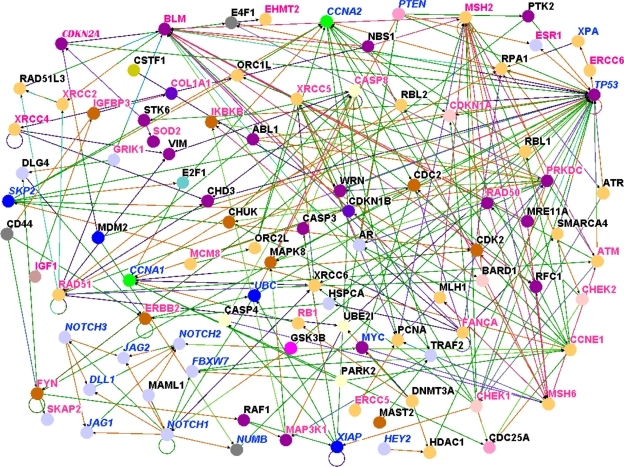


      ocr_spec locale
18     2021 el     en
46  2021 en+el     en

"CCNA2\nMSH2\nPTK2\nBLM\nΧΡΑ\nESR1\nCSTF1\nORC1\nRPA1\nERCC-\nRAD51L3'\nRBL2\nSTK6\nXRC94.\nΑBL1\nRBL1\nDLG4\nPRkpc\nWBN\nΑTR\nCHD3\nMRE1 1A\nSMARCA4\nCHUK\nC044\nCASP3\nAR\nORC2L\nΜΑΡΚ&\nMCMB\nΑTΜ\n. ΒARD1\nRFC1,\nGHEK2\nCASP43\nRBI\nΝΟTCH3\nLPCNA\nΝΟTCH2\n-GSK3B\nCCNE1\nJAG2\nFBXWT\nPARK\nDNMT3A;\nERCC .\nMAST2\nRAF1\nNUMB\nΧΙΑΡ\n. HDAC1\n,CDC25A\n"

     ocr_spec locale
102   2021 fy     en
116  2021 got     en

'CCNA2\nPTEN\nMSH2\nPTK2\nE4F1 EHMT2\nBLM\nCDKN24\nNBS1\nESR1\nXPA\nTP53\nCSTF1\nORCIL\nRPA1\nERCC6\nRAD51L3\nCOL1A1\nCASP3\nXRCC2\nXrccs\nRBL2\nIGEBP3\nSTK6\nCOKNIA\nIKBKB\nXRCC4\nSOD2\nABL1\nGRIK1\nVIM\nRBL1\nDLG4\nE2F1\nCDC2\nPRKOC\nWRN\nSKP\nCHD3\nATR\nCDKNB\nKIRAD58\nCHUK\nMRE11A\nCD44\nCASP3\nMDM2\nSMARCA4\nORC2L\nAR\nCDK2\nMCMS\nMAPK8\nATM\nIGF1\nCCNAT\nXRCC6\nBARD1\nRADS\nRFC1\nSUBC\nMLH1\nHSPCA\nCHEK2\nTERBB> CASP4 RBI\nUBE21\nNOTCH3\nFANÇA\nNOTCH2\nPCNA\nGSK3B\nMYC\nCCNE1\nJAG2\nTRAF2\nFBXW7\nPARK2

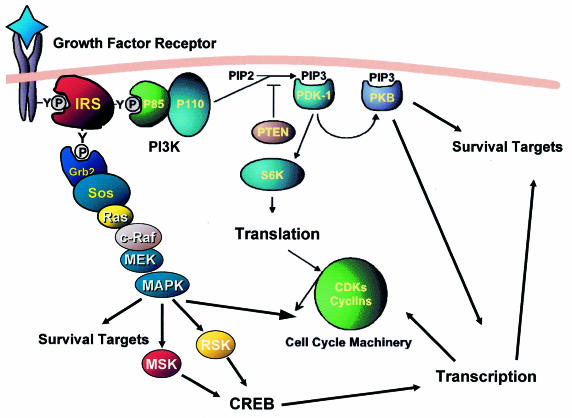


      ocr_spec locale
19     2021 el     en
47  2021 en+el     en

'Growth Factor Receptor\nP13K\nSurvival Targets\nGrb>\nSos\nTranslatioη\nΜΕΚ)\nSurvival Targets\nCell Cycle Machinery\n(MSK\nTranscription\nCREB\n'

            ocr_spec locale
61    2021 en+got+el     en
75   2021 en+got+grc     en
89       2021 en+grc     en
103          2021 fy     en
117         2021 got     en
131      2021 got+el     en
145  2021 got+el+grc     en
159     2021 got+grc     en
173         2021 grc     en

'Growth Factor Receptor\nPIP2\nPIP3\nPDK-1\nPIP3\nPKB\nFYⓇIRS Y P85 P110\nCTEN\nSurvival Targets\nS6K\nPI3K\nGrb\nSos\nRas\nC-Raf\nMEK\nMAPK\nTranslation\nCDKs\nCyclins\nSurvival Targets\nMSK\n(RSK\nCell Cycle Machinery\nTranscription\nCREB\n'

   ocr_spec locale
33  2021 en     en

'Growth Factor Receptor\nPIP2\nPIP3\nPIP3\nPDK-1\nPKB\nYO IRS YO P85 P110\nPTEN\nPI3K\nSurvival Targets\nGrb2\nS6K\nSos\nRas\nC-Raf\nMEK\nTranslation\nMAPK\nCDKS\nCyclins\nSurvival Targets\nRSK\nCell Cycle Machinery\nM

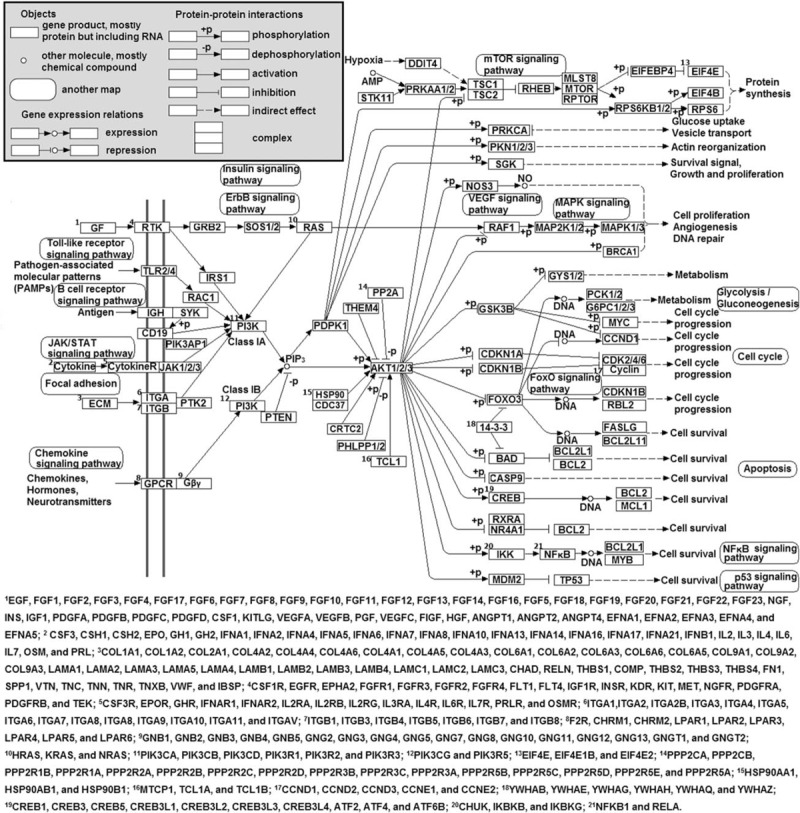


     ocr_spec locale
104   2021 fy     en
118  2021 got     en

'*P\n*PGSK3B\np\nONA\n*p Foxos\nObjects\nProtein-protein interactions\ngene product, mostly\nprotein but including RNA\nphosphorylation\nother molecule, mostly\ndephosphorylation Hypoxia - DDITA\nm TOR signaling\nchemical compound\nactivation\npathway\n+P EIFEBP4EF4E\nAMP\nMLSTS\nTSC1\nProtein\nanother map\ninhibition\nPRKAA1/2\nRHEB MTOR\nSTK11\nTSC2\nRPTOR\n+PE1F4B\n#p\nsynthesis\nGene expression relations\nindirect effect\n-RPS6KB12. RP $6\n+P\n*p\nGlucose uptake\nexpression\nPRKCA\nVesicle transport\ncomplex\n+p\nrepression\nPKN12/3\nActin reorganization\nInsulin signaling\nSGK\nSurvival signal,\nNO\npathway\nGrowth and proliferation\nNOS3\nErbB signaling\nVEGF signaling\nMAPK signaling\npathway\npathway\npathway\nCell proliferation\nGF RTK GRB2SOS12 RAS\nRAF1 . MAP2K112. MAPK173 Angiogenesis\nToil-like receptor\nDNA repair\nsignaling pathway\nBRCA1\nPathogen-associated\nTLR214\n+p\nmolecular patterns\nIRS1\nGYS112\nM

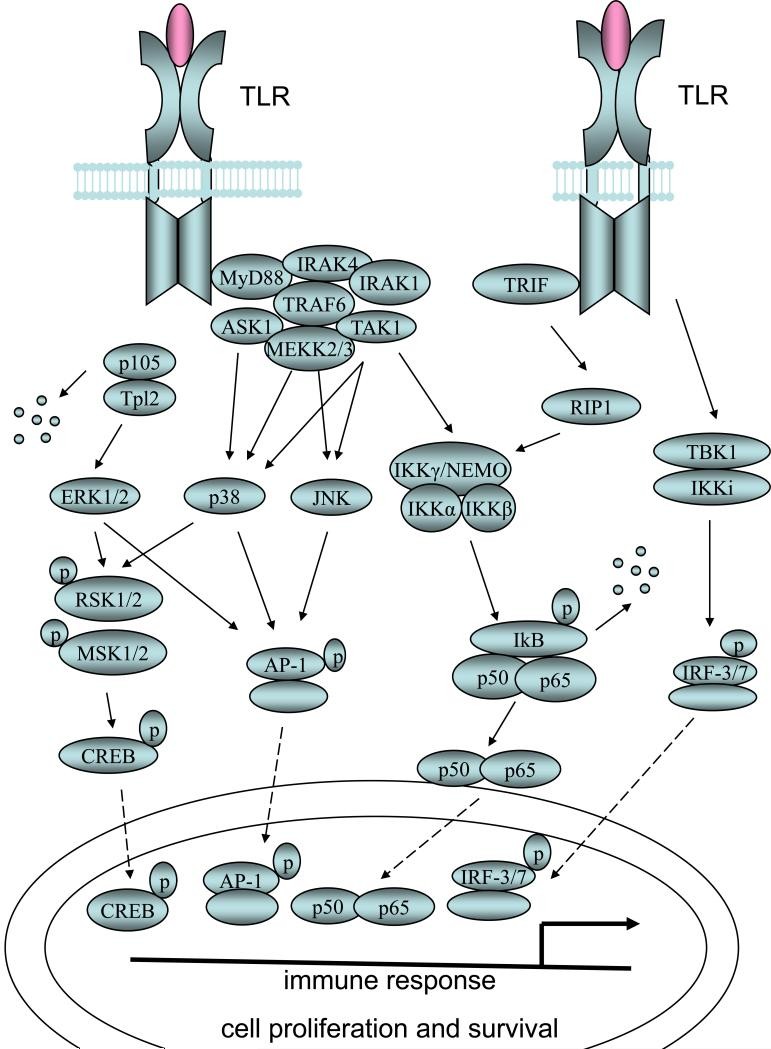


      ocr_spec locale
21     2021 el     en
49  2021 en+el     en

'TLR\nTLR\n(MYD88>\nTRAF6)\nIRAK4\nIRAKI\nTRIF\nASKI)\nΜΕΚΚ2/3)\nΤΑΚΙ\np105\nTpl2\nRIP1\nΚΚΥΝΕΜΟ\nERK 1/2)\np38\nJNK\nRSK1/2\nMSK 1/2\np50\np65\nIRF-3/7\nCREB\np50\np65\nRF-3/7\nCREB\np50\np65\nimmune response\ncell proliferation and survival\n'

           ocr_spec locale
8  2019 unspecified     en

'TLR\nTLR\nIRAK4\nIRAK1\nMYD88\nTRAF6\nTRIF\nASK1\nMEKK2/3\nTAK1\np105\nTpl2\nRIP1\nTBK1\n(IKKY/NEMO\nIKKI\nERK1/2\np38\nJNK\n(IKKA IKKB\nRSK1/2\nIkB\nMSK1/2\nAP-1\nIRF-3/7\np50\np65\nCREB\np50\np65\nIRF-3/7\np50\np65\nCREB\nimmune response\ncell proliferation and survival\n'

   ocr_spec locale
35  2021 en     en

'TLR\nTLR\nMYD88\nTRAF6\nIRAK4\nIRAK1\nTRIF\nASK1\nMEKK2/3\nTAK1\np105\nTpl2\nRIP1\nTBK1\n(IKKY/NEMO\nIKKI\nERK1/2\np38\nJNK\n(IKKA IKKB\nRSK1/2\nIkB\nMSK1/2\nAP-1\nIRF-3/7\np50\np65\nCREB\np50\np65\nIRF-3/7\nCREB\np50\np65\nimmune response\ncell proliferation and survival\n'

             ocr_spec locale
189  2

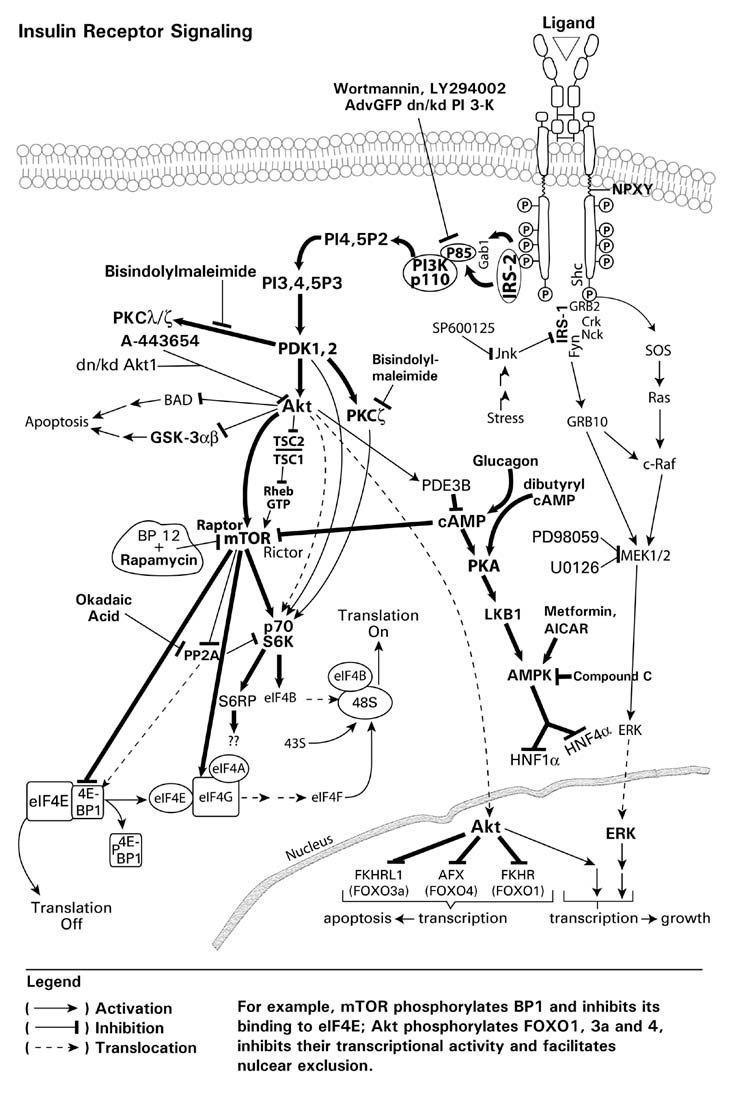


            ocr_spec locale
64    2021 en+got+el     en
78   2021 en+got+grc     en
92       2021 en+grc     en
106          2021 fy     en
120         2021 got     en
134      2021 got+el     en
148  2021 got+el+grc     en
162     2021 got+grc     en
176         2021 grc     en

'Insulin Receptor Signaling\nLigand\nWortmannin, LY294002\nAdvGFP dn/kd PI 3-K\nP14,5P2\nr\nBisindolylmaleimide\nP13,4,5P3\nP85)\nPI3K\np110\nIRS-23\nPKCW/\nA-443654\ndn/kd Akt1\nCrk\nNck\nPDK1,2\nSP600125\nBisindolyl-\nInk\nmaleimide\nSOS\n+ BADE\nRas\nApoptosis\nPKCS\nStress\nGRB10\nGSK-3aß\nAkt\n1\nTSC2\nTSC1\nC-Raf\nGlucagon\nPDE3B dibutyryl\n1\nCAMP\nRheb\nGTP\nCAMP\nBP 12\nRapamycin\nRaptor\nmTOR\nRictor\nPD98059\nMEK1/2\nU0126\nPKA\nOkadaic\nAcid\nw\nLKB1\np70\nSOK\nTranslation\nOn\nMetformin,\nAICAR\nApp2A\nAMPK Compound\nelF4B\nSORP elF4B --\n485\nERK\n??\n435\nHNF40.\nHNF1a\nelF4A\nlelF4E|BP1)\n4E-\n(elF4E elF4G -->--> elF4F\nAkt\nERK\n24E-\nBP1)\nNucleus\nFKHRL1 AFX FKHR\n(FOXO3a) (FOX04) (FOX01)\n

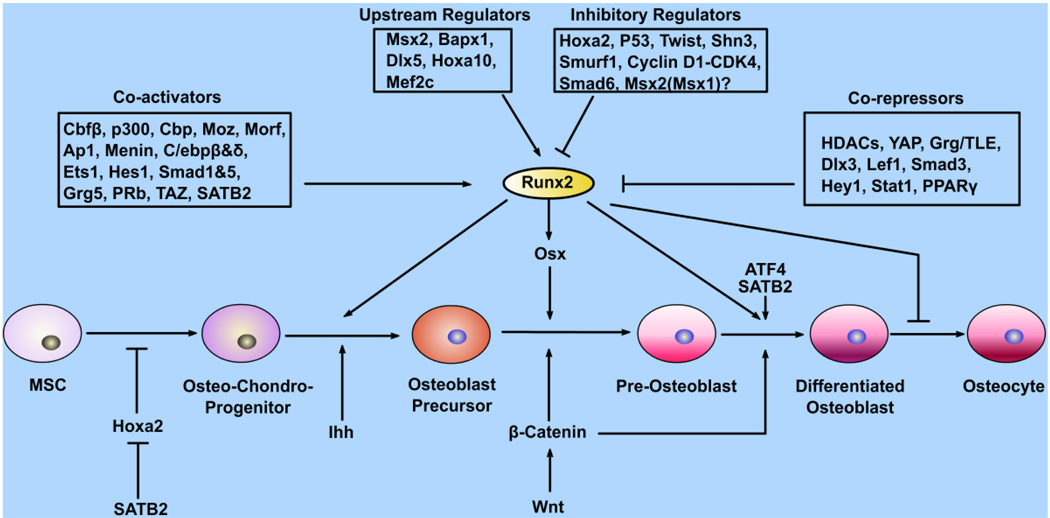


           ocr_spec locale
9  2019 unspecified     en

'Upstream Regulators\nMsx2, Bapx1,\nDIx5, Hoxa10,\nMef2c\nInhibitory Regulators\nHoxa2, P53, Twist, Shn3,\nSmurf1, Cyclin D1-CDK4,\nSmad6, Msx2(Msx1)?\nCo-activators\nCo-repressors\nCbfß, p300, Cbp, Moz, Morf,\nAp1, Menin, C/ebpß&d,\nEts1, Hes1, Smad1&5,\nGrg5, PRb, TAZ, SATB2\nHDACS, YAP, Grg/TLE,\nDIx3, Lef1, Smad3,\nHey1, Stat1, PPARY\nRunx2\nOsx\nATF4\nSATB2\nMSC\nOsteo-Chondro-\nProgenitor\nOsteoblast\nDifferentiated\nOsteocyte\nPre-Osteoblast\nPrecursor\nOsteoblast\nHoxa2\nB-Catenin\nIhh\nWnt\nSATB2\nO)\n'

             ocr_spec locale
37            2021 en     en
191  2021 unspecified     en

'Upstream Regulators\nMsx2, Bapx1,\nDIx5, Hoxa10,\nMef2c\nInhibitory Regulators\nHoxa2, P53, Twist, Shn3,\nSmurf1, Cyclin D1-CDK4,\nSmad6, Msx2(Msx1)?\nCo-activators\nCo-repressors\nCbfß, p300, Cbp, Moz, Morf,\nAp1, Menin, C/ebpß&d,\nEts1, Hes1, Smad1&5,\nGrg5, PRb, TAZ, SATB2\nHDACS, YAP, Grg/TLE,\nDIx3, Lef1, Smad3,\nHey1, Stat1, PPA

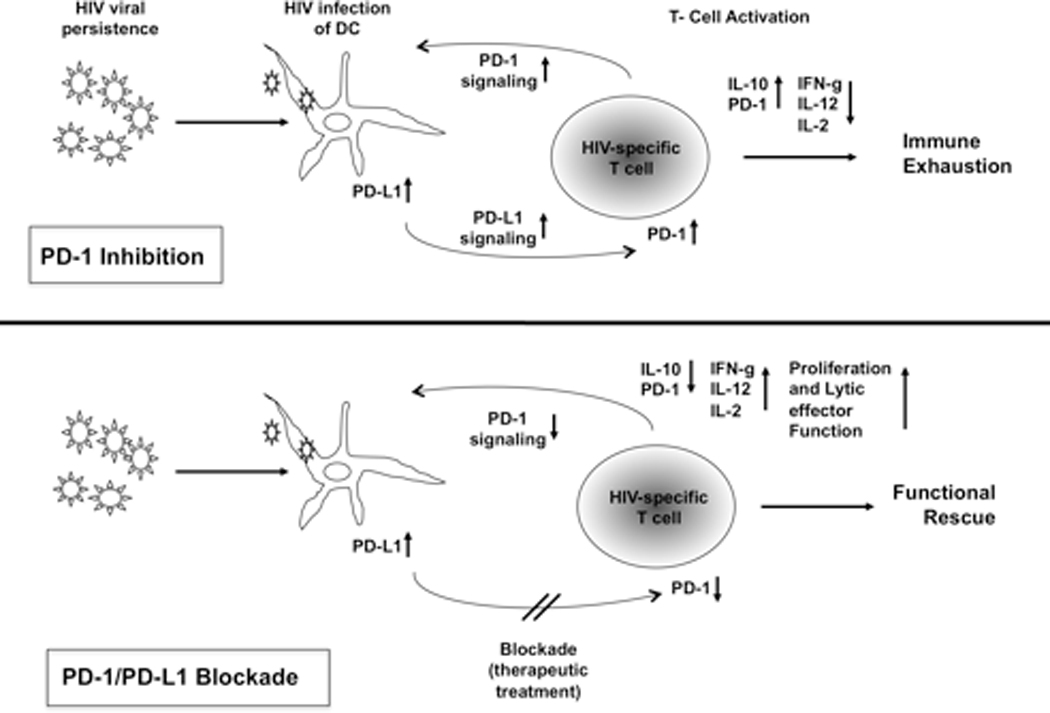


            ocr_spec locale
10  2019 unspecified     en

'HIV infection\nHIV viral\nT- Cell Activation\npersistence\nof DC\nPD-1\nsignaling\nIL-10\nPD-1\nIL-12\nIL-2\nImmune\nExhaustion\nHIV-specific\nT cell\nPD-L11\nPD-L1\nPD-11\nsignaling\nPD-1 Inhibition\nProliferation\nand Lytic\neffector\nFunction\nIL-10 | IFN-g\nPD-1\nIL-12\nIL-2\nPD-1\nsignaling\nFunctional\nHIV-specific\nT cell\nRescue\nPD-L11\n→ PD-1!\nBlockade\n(therapeutic\ntreatment)\nPD-1/PD-L1 Blockade\n'

      ocr_spec locale
24     2021 el     en
52  2021 en+el     en

"HIV vira\nΗIV infoction\nT.Cell Activation\npersistence\nof DC\nPD-1\nsignaling\nL-10\nPD-1\n1-12\nHIV-specific\nTcol\nImmune\nExhaustion\nPD-L1\nsignaling\nPD-1 Inibition\nL10 1 FN-g\nL-12\nProliferation\nand Lytic\ncffector\nFunction\nL-2\nPD-1\nsignaling '\nFunctional\nHIV-spocific\nTcoll\nRescue\nBlockade\n( therapeutc\ntreatment)\nPD-1/PD-L1 Blockade\n"

             ocr_spec locale
38            2021 en     en
192  2021 unspecified     en

'HIV v

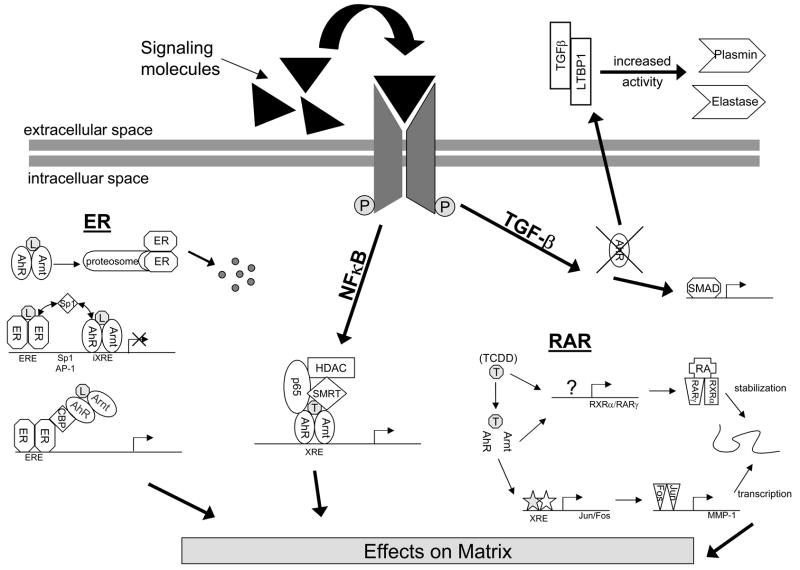


      ocr_spec locale
25     2021 el     en
53  2021 en+el     en

'Plasmin\nSignaling\nmolecules\nincreased\nactivity\nElastase)\nextracellular space\nintracelluar space\nTGF-B\nER\nER\n(ρroteosom(ER\nSMAD)\nRAR\n(TCDD)\nIRA\nERE\nSpt\nXRE\nHDAC\nstabilization\nSMRT)\nRXRu RAR\nAnR\nXRE\nERE\nranscription\nJurFos.\nMMP-1\nXRE\nEffects on Matrix\nLTBP1\nTGFA\nΝΕKB\nArnty\nAhR)\np65\nArnt\n(AhR\nArnty\nER\nER\nAhR)\nER\nER\n'

   ocr_spec locale
39  2021 en     en

'Plasmin\nincreased\nSignaling\nmolecules\nactivity\nElastase\nextracellular space\nintracelluar space\n(P\nP\nTGF-B\nER\nER\nproteosome ER\nSMAD\nSp\nRAR\n(TCDD)\n[RA\nIXRE\nHDAC\nstabilization\nSp1\nAP-1\n?\nERE\nSMRT\nRXRa/RARY\n(Arnt\nAhR\nXRE\nERE\ntranscription\nMMP-1\nJun/Fos\nXRE\nEffects on Matrix\nRAR\nLTBP1\nTGFB\nNFKB\nArnt\nAhR\np65\nArnt\nAhR\nArnt\nER\nER\nAhR\nER\nER\n'

             ocr_spec locale
193  2021 unspecified     en

'Plasmin\nincreased\nSignaling\nmolecules\nactivity\nElastase\nextracellular spac

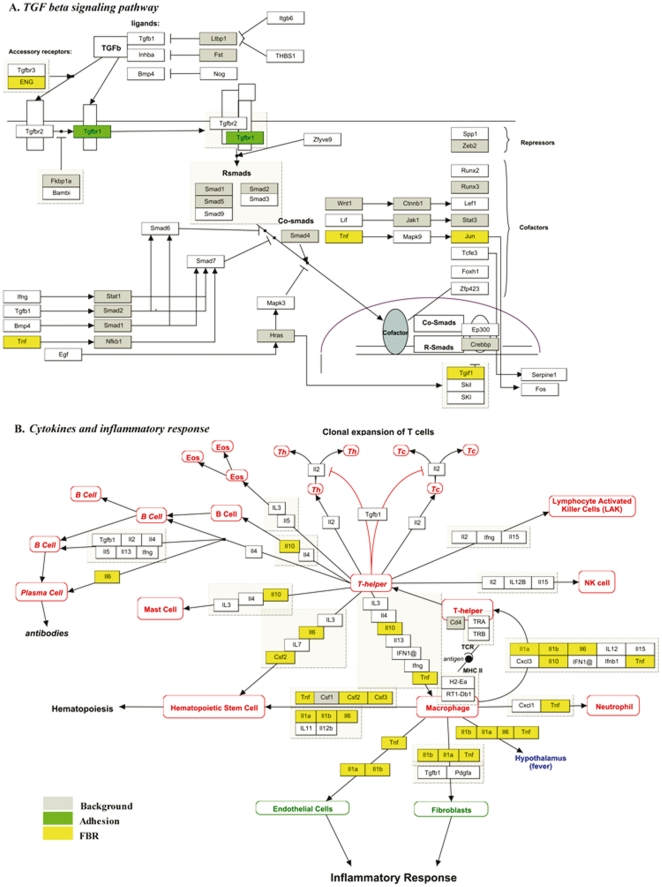


             ocr_spec locale
26            2021 el     en
40            2021 en     en
54         2021 en+el     en
68     2021 en+got+el     en
82    2021 en+got+grc     en
96        2021 en+grc     en
110           2021 fy     en
124          2021 got     en
138       2021 got+el     en
152   2021 got+el+grc     en
166      2021 got+grc     en
180          2021 grc     en
194  2021 unspecified     en

'A. TGF beta signaling pathway\nligands:\nΤρ1\nAccessory receptors\nTGFb\nLip1\nFut\nTHES\nBros\nNog\nENG\nTobre\nSopt\nZuba\nRepressions\nFiboto\nBam\nRun 2\nRund\nRamads\nSmadt\nSmads\nSmas\nSmade\nWind\nCint\nCo-smads\nLI\nSmall\nCofactors\nSma\nTel\nMapa\nTee\nSmad\nFox\nStat\nMapia\ning\n1961\nBm\nSmade\nSmad\nCo-Smads\nCofacto\nE300\nTel\nN1\nR-Smads\nCretop\nEg!\nToint\nSerpinet\nFos\nSKI\nB. Cytokines and inflammatory response\nClonal expansion of T cells\nEos\nTe)\nEos\nEos\nB Cell\nLymphocyte Activated\nKiller Cells (LAK)\nB Cell\nB Cell\nH\ning\n1115\nB Cell\n10\n113\nT-help

In [15]:
import time

for figure_path, df in ocr_df.groupby(by=["figure_path"], dropna=False):
    print(f"================ {figure_path} ================")
    display(Image(filename=figure_path))
    print("")
    for text, sub_df in df.groupby(by=["text"], dropna=False):
        print(sub_df[["ocr_spec", "locale"]])
        print("")
        print(repr(text))
        print("")
    print("")
    time.sleep(1)